In [3]:
pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import os
import scipy
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader as DL
from torch.utils.data import TensorDataset as TData
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split as tts
import pickle

from scipy.signal import butter, filtfilt
from PyEMD import EMD
from scipy.stats import skew, kurtosis

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [6]:
root = '/content/drive/MyDrive/Longhorn Neurotech/LHNT_pickles/'

In [70]:
# Base folder containing the files
# right_session_folder = os.path.join(root, "alan_f_right/session_1")

# Initialize a dictionary to store the loaded signals
right_eeg_data = {}

# Iterate through files labeled in increments of two
for j in range(1, 7):
  right_session_folder = os.path.join(root, f"nandini_right/session_{j}")
  for i in range(2, 21, 2):  # Adjust the range as needed
      file_path = os.path.join(right_session_folder, f"right_{i}.pkl")

      # Check if the file exists
      if os.path.exists(file_path):
          with open(file_path, "rb") as file:
              data = pickle.load(file)
              right_eeg_data[f"right_{j}_{i}"] = data  # Store the data with the corresponding label
      else:
          print(f"File not found: {file_path}")
          break  # Stop if the file sequence ends

left_eeg_data = {}

for j in range(1, 7):
  left_session_folder = os.path.join(root, f"nandini_left/session_{j}")
  # Iterate through files labeled in increments of two
  for i in range(1, 20, 2):  # Adjust the range as needed
      file_path = os.path.join(left_session_folder, f"left_{i}.pkl")

      # Check if the file exists
      if os.path.exists(file_path):
          with open(file_path, "rb") as file:
              data = pickle.load(file)
              left_eeg_data[f"left_{j}_{i}"] = data  # Store the data with the corresponding label
      else:
          print(f"File not found: {file_path}")
          break  # Stop if the file sequence ends



right_signal_data = {label: signal[0] for label, signal in right_eeg_data.items()}
right_metadata = {label: signal[1] for label, signal in right_eeg_data.items()}

left_signal_data = {label: signal[0] for label, signal in left_eeg_data.items()}
metadata = {label: signal[1] for label, signal in left_eeg_data.items()}



In [71]:
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler

def baseline_correction(signal):
    """
    Removes baseline offset by subtracting the mean of each channel.

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).

    Returns:
        np.ndarray: Baseline-corrected signal.
    """
    return signal - np.mean(signal, axis=1, keepdims=True)


def bandpass_filter(signal, lowcut=13, highcut=30, fs=125, order=4):
    """
    Band-pass filters the signal for the specified frequency range.

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).
        lowcut (float): Lower cutoff frequency (Hz).
        highcut (float): Upper cutoff frequency (Hz).
        fs (float): Sampling rate (Hz).
        order (int): Order of the filter.

    Returns:
        np.ndarray: Band-pass filtered signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal, axis=1)

def normalize_signal(signal):
    """
    Normalizes the signal for each channel (z-score normalization).

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).

    Returns:
        np.ndarray: Normalized signal.
    """
    scaler = StandardScaler()
    return scaler.fit_transform(signal.T).T  # Transpose to normalize each channel

def preprocess_eeg(signal, fs=256):
    """
    Preprocess EEG signal with baseline correction, band-pass filtering, and normalization.

    Parameters:
        signal (np.ndarray): EEG signal with shape (channels, samples).
        fs (float): Sampling rate (Hz).

    Returns:
        np.ndarray: Preprocessed EEG signal.
    """
    # Step 1: Baseline Correction
    signal_corrected = baseline_correction(signal)

    # Step 2: Band-Pass Filter (Beta Frequencies)
    signal_filtered = bandpass_filter(signal_corrected, lowcut=4, highcut=40, fs=fs)

    # Step 3: Normalization
    signal_normalized = normalize_signal(signal_filtered)

    return signal_normalized

def sliding_window_augmentation(data, labels, window_size=125, stride=80):
    """
    Apply sliding window to already EMD-processed data

    Args:
    data: numpy array of shape (n_samples, n_channels*n_imfs, time_steps)
    labels: numpy array of shape (n_samples,)
    window_size: size of sliding window
    stride: step size for sliding window

    Returns:
    augmented_data, augmented_labels
    """
    n_samples, n_features, time_steps = data.shape
    n_windows = (time_steps - window_size) // stride + 1

    augmented_data = np.zeros((n_samples * n_windows, n_features, window_size))
    augmented_labels = np.zeros(n_samples * n_windows, dtype=labels.dtype)

    idx = 0
    for i in range(n_samples):
        for j in range(n_windows):
            start = j * stride
            end = start + window_size
            augmented_data[idx] = data[i, :, start:end]
            augmented_labels[idx] = labels[i]
            idx += 1

    return augmented_data, augmented_labels

In [72]:
# Preprocess each signal in the dictionary
right_preprocessed_signals = {label: preprocess_eeg(signal, fs=256) for label, signal in right_signal_data.items()}

# Inspect the shapes of the processed signals
for label, signal in right_preprocessed_signals.items():
    print(f"{label}: RIGHT Processed Signal Shape = {signal.shape}")


# Preprocess each signal in the dictionary
left_preprocessed_signals = {label: preprocess_eeg(signal, fs=256) for label, signal in left_signal_data.items()}

# Inspect the shapes of the processed signals
for label, signal in left_preprocessed_signals.items():
    print(f"{label}: LEFT Processed Signal Shape = {signal.shape}")

right_1_2: RIGHT Processed Signal Shape = (16, 875)
right_1_4: RIGHT Processed Signal Shape = (16, 875)
right_1_6: RIGHT Processed Signal Shape = (16, 875)
right_1_8: RIGHT Processed Signal Shape = (16, 875)
right_1_10: RIGHT Processed Signal Shape = (16, 875)
right_1_12: RIGHT Processed Signal Shape = (16, 875)
right_1_14: RIGHT Processed Signal Shape = (16, 875)
right_1_16: RIGHT Processed Signal Shape = (16, 875)
right_1_18: RIGHT Processed Signal Shape = (16, 875)
right_1_20: RIGHT Processed Signal Shape = (16, 875)
right_2_2: RIGHT Processed Signal Shape = (16, 875)
right_2_4: RIGHT Processed Signal Shape = (16, 875)
right_2_6: RIGHT Processed Signal Shape = (16, 875)
right_2_8: RIGHT Processed Signal Shape = (16, 875)
right_2_10: RIGHT Processed Signal Shape = (16, 875)
right_2_12: RIGHT Processed Signal Shape = (16, 875)
right_2_14: RIGHT Processed Signal Shape = (16, 875)
right_2_16: RIGHT Processed Signal Shape = (16, 875)
right_2_18: RIGHT Processed Signal Shape = (16, 875)
r

In [73]:
left_labels = np.array([0 for _ in range(len(left_preprocessed_signals))])
right_labels = np.array([1 for _ in range(len(right_preprocessed_signals))])

left, left_labels = sliding_window_augmentation(np.array(list(left_preprocessed_signals.values())), np.array(left_labels), window_size=80, stride=60)
right, right_labels = sliding_window_augmentation(np.array(list(right_preprocessed_signals.values())), np.array(right_labels), window_size=80, stride=60)

In [74]:
left.shape, right.shape, left_labels.shape, right_labels.shape

((840, 16, 80), (840, 16, 80), (840,), (840,))

# Data Augmentation Functions

In [ ]:
import numpy as np
from PyEMD import EMD

n_samples, n_channels, n_time = processed_data.shape
n_imfs_to_keep = 5  # Adjust based on your signals

# Initialize EMD and store decomposed IMFs
emd = EMD()
imfs_dataset = []

for sample in range(n_samples):
    imfs_sample = []
    if sample % 10 == 0:
        print(f"Processing sample {sample+1}/{n_samples}")
    for channel in range(n_channels):
        signal = processed_data[sample, channel, :]
        imfs = emd(signal)  # Decompose into IMFs
        n_imfs = imfs.shape[0]

        # Pad with zeros if fewer IMFs than n_imfs_to_keep
        if n_imfs < n_imfs_to_keep:
            pad_width = n_imfs_to_keep - n_imfs
            imfs = np.pad(imfs, ((0, pad_width), (0, 0)), mode='constant')
        else:
            imfs = imfs[:n_imfs_to_keep, :]

        # Include residue (original signal - sum of IMFs)
        residue = signal - np.sum(imfs, axis=0)
        components = np.vstack([imfs, residue[np.newaxis, :]])
        imfs_sample.append(components)

    # Stack components across channels: (16*6, 875)
    imfs_sample = np.vstack(imfs_sample)  # Shape: (16*(n_imfs+1), 875)
    imfs_dataset.append(imfs_sample)

print(len(imfs_dataset), len(imfs_dataset[0]))
for sample in range(len(imfs_dataset)):
    for channel in range(len(imfs_dataset[0])):
        channel_data = imfs_dataset[sample][channel]
        std = np.std(channel_data)
        # Check for zero standard deviation before normalization
        if std != 0:
            imfs_dataset[sample][channel] = (channel_data - np.mean(channel_data)) / std
        else:
            # If std is zero, avoid division and potentially replace with zeros or another strategy
            imfs_dataset[sample][channel] = channel_data - np.mean(channel_data)  # Or replace with zeros: imfs_dataset[sample][channel] = 0

imfs_dataset = np.array(imfs_dataset)


Processing sample 1/200
Processing sample 11/200
Processing sample 21/200
Processing sample 31/200
Processing sample 41/200
Processing sample 51/200
Processing sample 61/200
Processing sample 71/200
Processing sample 81/200
Processing sample 91/200
Processing sample 101/200
Processing sample 111/200
Processing sample 121/200
Processing sample 131/200
Processing sample 141/200
Processing sample 151/200
Processing sample 161/200
Processing sample 171/200
Processing sample 181/200
Processing sample 191/200
200 96


In [ ]:
# Assuming 'eeg_data' is your NumPy array
nan_proportion = np.isnan(imfs_dataset).sum() / imfs_dataset.size
print(f"Proportion of NaN values: {nan_proportion}")

Proportion of NaN values: 0.0


In [ ]:
# run only one of these:

In [ ]:
augmented_data, augmented_labels = imfs_dataset, labels

In [ ]:
augmented_data, augmented_labels = sliding_window_augmentation(imfs_dataset, labels)

In [ ]:
augmented_data.shape, augmented_labels.shape

((2200, 96, 125), (2200,))

In [ ]:
def visualize_imfs(sample_idx, channel_idx, imfs):
    """
    Visualize IMFs for a specific channel of a specific sample
    """
    n_imfs = 5
    plt.figure(figsize=(12, 8))

    # Plot original signal
    plt.subplot(n_imfs + 1, 1, 1)
    plt.plot(processed_data[sample_idx, channel_idx])
    plt.title(f'Original Signal - Channel {channel_idx}')

    # Plot IMFs
    for i in range(n_imfs):
        plt.subplot(n_imfs + 1, 1, i + 2)
        plt.plot(imfs[i])
        plt.title(f'IMF {i+1}')

    plt.tight_layout()
    plt.show()

In [ ]:
imfs_dataset.shape

(120, 96, 875)

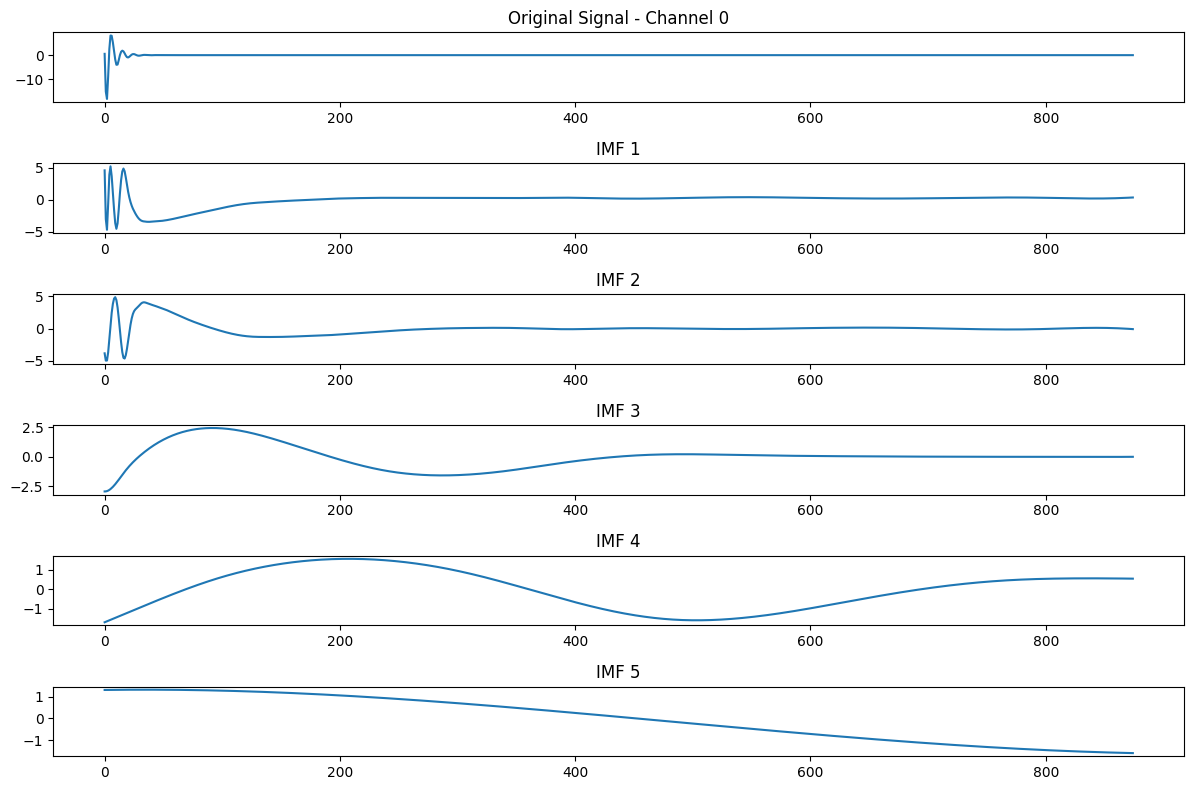

In [ ]:
visualize_imfs(0, 0, augmented_data[0])

# model things


In [75]:
# run this if no EMD!
augmented_data = np.concatenate((left, right))
augmented_labels = np.concatenate((left_labels, right_labels))


In [76]:
augmented_labels

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
import torch
import torch.nn as nn

class EMD_PCNN(nn.Module):
    def __init__(self, input_channels=16, num_classes=2, input_length=80):
        super().__init__()

        # Branch 1 (input_length = 125)
        # Branch 1 (input_length = 125)
        self.branch1 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=20, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),  # Output length: 125 // 2 = 62
            # nn.Conv1d(16, 32, kernel_size=10, padding='same'),
            # nn.BatchNorm1d(32),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.MaxPool1d(2)  # Output length: 62 // 2 = 31
        )

        # Branch 2 (input_length = 125)
        self.branch2 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=10, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),  # Output length: 125 // 2 = 62
            # nn.Conv1d(16, 32, kernel_size=5, padding='same'),
            # nn.BatchNorm1d(32),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.MaxPool1d(2)  # Output length: 62 // 2 = 31
        )

        # Calculate FC input dimension dynamically
        with torch.no_grad():
            example_input = torch.randn(1, input_channels, input_length)
            out1 = self.branch1(example_input)
            out2 = self.branch2(example_input)
            self.fc_input_dim = out1.numel() + out2.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out1 = self.branch1(x)  # Shape: (batch, 32, 31)
        out2 = self.branch2(x)  # Shape: (batch, 32, 31)
        combined = torch.cat([out1.flatten(1), out2.flatten(1)], dim=1)  # Shape: (batch, 32*31 + 32*31) = (batch, 1984)
        return self.fc(combined)

In [77]:
class PCNN_3Branch(nn.Module):
    def __init__(self, input_channels=16, num_classes=2, input_length=80):
        super().__init__()


        self.branch1 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=20, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )


        self.branch2 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=10, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )

        self.branch3 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )

        self.branch4 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, padding='same'),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )


        with torch.no_grad():
            example_input = torch.randn(1, input_channels, input_length)
            out1 = self.branch1(example_input)
            out2 = self.branch2(example_input)
            out3 = self.branch3(example_input)
            out4 = self.branch4(example_input)
            self.fc_input_dim = out1.numel() + out2.numel() + out3.numel() + out4.numel()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        combined = torch.cat([out1.flatten(1), out2.flatten(1), out3.flatten(1), out4.flatten(1)], dim=1)
        return self.fc(combined)

In [79]:
X.shape, y.shape

(torch.Size([1680, 16, 80]), torch.Size([1680]))

In [81]:
from torch.utils.data import DataLoader, TensorDataset, random_split
class EEGAugmenter:
    def __call__(self, sample):
        if np.random.rand() > 0.5:
            # Add Gaussian noise
            noise = torch.randn_like(sample) * 0.01
            sample += noise
        if np.random.rand() > 0.5:
            # Random shift (up to 5 timesteps)
            shift = np.random.randint(-5, 5)
            sample = torch.roll(sample, shifts=shift, dims=-1)
        return sample


# Convert to PyTorch tensors
X = torch.tensor(augmented_data, dtype=torch.float32)
y = torch.tensor(augmented_labels, dtype=torch.long)  # Ensure labels are integers

# Split into train/validation (80/20)
dataset = TensorDataset(X, y)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 24  # Adjust based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=EEGAugmenter())
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=EEGAugmenter())

In [82]:
print(len(train_loader), len(val_loader))

49 21


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PCNN_3Branch(input_channels=16, num_classes=2).to(device)  # Adjust num_classes
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [84]:
# Check for NaNs/Infs in data and labels
assert not torch.isnan(X).any(), "Input data contains NaNs!"
assert not torch.isinf(X).any(), "Input data contains Infs!"
assert torch.all(y >= 0) and torch.all(y < 2), "Invalid labels!"

In [85]:
num_epochs = 30  # Adjust based on early stopping
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss, correct_train, total_train = 0, 0, 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)

        # Add these checks
        if torch.isnan(outputs).any():
            print("NaN in model outputs!")
            break
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()

    # Validation phase
    model.eval()
    epoch_val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()

    # Compute epoch metrics
    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(val_loader)
    train_acc = correct_train / total_train
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if epoch % 2 == 0:
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")
        print("----------------------------------")


Epoch 1/30
Train Loss: 0.7320 | Val Loss: 0.6991
Train Acc: 50.26% | Val Acc: 47.62%
----------------------------------
Epoch 3/30
Train Loss: 0.6721 | Val Loss: 0.7060
Train Acc: 59.95% | Val Acc: 46.43%
----------------------------------
Epoch 5/30
Train Loss: 0.6428 | Val Loss: 0.7157
Train Acc: 63.95% | Val Acc: 48.02%
----------------------------------
Epoch 7/30
Train Loss: 0.5978 | Val Loss: 0.7303
Train Acc: 69.13% | Val Acc: 47.62%
----------------------------------
Epoch 9/30
Train Loss: 0.5693 | Val Loss: 0.7343
Train Acc: 71.26% | Val Acc: 49.21%
----------------------------------
Epoch 11/30
Train Loss: 0.5243 | Val Loss: 0.7402
Train Acc: 76.02% | Val Acc: 48.81%
----------------------------------
Epoch 13/30
Train Loss: 0.4778 | Val Loss: 0.7787
Train Acc: 77.89% | Val Acc: 48.41%
----------------------------------
Epoch 15/30
Train Loss: 0.4395 | Val Loss: 0.7584
Train Acc: 81.04% | Val Acc: 49.01%
----------------------------------
Epoch 17/30
Train Loss: 0.4072 | Val 

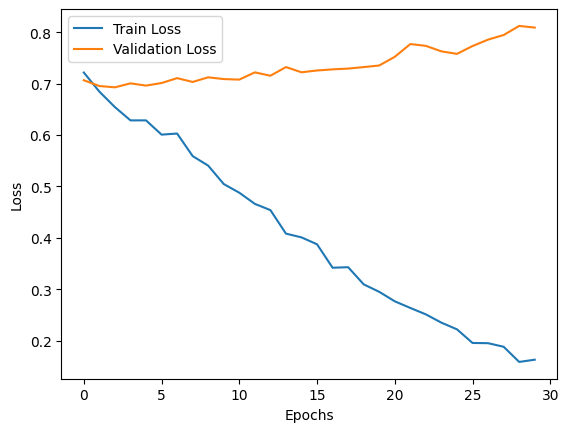

In [62]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()